In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)
    

iteration:,   0, ps_str, 148.081582
iteration:,   1, ps_str, 1282.173562
iteration:,   2, ps_str, 1281.742148
iteration:,   3, ps_str, 13046.180248
iteration:,   4, ps_str, 148.081582
iteration:,   5, ps_str, 148.081582
iteration:,   6, ps_str, 13044.874888
iteration:,   7, ps_str, 13044.766546
iteration:,   8, ps_str, 13045.579739
iteration:,   9, ps_str, 1282.162389
iteration:,  10, ps_str, 516.850132
iteration:,  11, ps_str, 13044.176224
iteration:,  12, ps_str, 13041.811930
iteration:,  13, ps_str, 13045.679982
iteration:,  14, ps_str, 1075.787014
iteration:,  15, ps_str, 148.081582
iteration:,  16, ps_str, 13046.628907
iteration:,  17, ps_str, 148.081582
iteration:,  18, ps_str, 13044.147724
iteration:,  19, ps_str, 13042.316733
iteration:,  20, ps_str, 1282.145563
iteration:,  21, ps_str, 13043.548870
iteration:,  22, ps_str, 148.081582
iteration:,  23, ps_str, 148.081582
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 13041.327941
iteration:,  26, ps_str, 13041.9809

In [2]:
#Coupling field enhancement

import meep as mp
import numpy as np
import matplotlib.pyplot as plt



def get_incident_value(cell_size, resolution, sources, pml_layers, d):

    print("$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$")
    
    default_material = mp.Medium(index=1.3325)

    resolution = 15/r

    sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            sources=sources,
            k_point=mp.Vector3()
        )
    
    sim.run(until=10) #10 fs

    d=0.3*d

    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(y=d), component=mp.Ez))

    return Ez_data_1D[0]



def get_sphere_coupling_enhancement(r, gap, wvl):
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq = 1 / wvl

    #50/r?
    resolution = 15/r
    
    dpml = 2*r
    dair = 2*r
    #defining gap between spheres. Can adjust later.
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #Fine to keep these since the system is still symmetric relative to these planes.
    symmetries = [mp.Mirror(mp.Y)]
    
    width = 2 * (dpml + dair + r)
    height = 2 * (dpml + dair + 2*r + 0.5*gap)
    cell_size = mp.Vector3(width, width, height)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.ContinuousSource(frequency=frq, is_integrated=True),
            center=mp.Vector3(-0.5*width + dpml, 0, 0),
            size=mp.Vector3(0, width, height),
            component=mp.Ez,
        )
    ]
    
    
    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0, 0.5*gap + r),
                  radius=r),
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0, -0.5*gap - r),
                  radius=r),
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        symmetries=symmetries,
        sources=sources,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    
    sim.run(until=10) #10 fs
    
    #grab data once run is finished i.e. what the system looks like at 200fs:
    d = 0.95*(height-2*dpml)
    w = width-2*dpml

    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(z=d), component=mp.Ez))

    incident_field_value = get_incident_value(cell_size, resolution, sources, pml_layers, d)

    eps_data_x = sim.get_array(center=mp.Vector3(), size=mp.Vector3(0, w, d), component=mp.Dielectric)
    Ex_data = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(0, w, d), component=mp.Ez))

    return Ez_data_1D, incident_field_value, Ex_data, eps_data_x




In [ ]:
# Varying Gap Size

wvl = 545E-3
r = 50E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
gap_labels = []
radii = []
inc_field_vals = []
E_data_vis = []
eps_data_vis = []


gap_min =6E-3
gap_max =15E-3
gaps = np.linspace(gap_max,gap_min,5)

index = 1

for gap in gaps:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_coupling_enhancement(r, gap, wvl)
    
    E_data.append(E_strength)
    gap_labels = np.append(gap_labels, round(gap, 2))
    radii = np.append(radii, r)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


In [ ]:
print(inc_field_vals)

FEF_values = []

index = 0

plt.figure()
for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = (radii[index]*5+gaps[index])/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))
    #Also converting axis to position from pixels. 100 being the resolution value.

    FEF_values.append(np.interp(0.0, space_1D, E_strength) / inc_field_vals[index])

    #plt.figure()
    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(gaps[index]),4))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Two Au Nanospheres, Varying Gap Size: z Axis Field Strength (incident λ = {wvl*1E3}nm, Radius = {r*1E3}nm)")
    plt.legend(loc="upper right", title = "Gap Size, nm", fontsize = 7, title_fontsize= 8)
    plt.tight_layout()
    
    index+=1

plt.savefig(fname="Two Au Nanospheres, Varying Gap Size: z Axis Field Strength",
        dpi=150, 
        bbox_inches="tight")

plt.figure()
plt.plot(1E3*gaps, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Gap size, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Gap Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Gap Size",
        dpi=150, 
        bbox_inches="tight")

print(1E3*gaps, FEF_values)
#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("y, px")
plt.ylabel("z, px")
plt.title(f"x plane: Two Au Nanospheres (λ = {1E3*wvl}nm)")
plt.savefig(fname="x plane: Two Au Nanospheres, greatest FEF, gap",
        dpi=150, 
        bbox_inches="tight")





for i in [0,1,2,3,4,]:
    plt.figure()
    plt.imshow(eps_data_vis[i].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[i].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("y, px")
    plt.ylabel("z, px")
    plt.title(f"run={radii[i]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.savefig(fname=f"r={int(i)}, x plane: Two Au Nanospheres, gap",
        dpi=150, 
        bbox_inches="tight")
    

In [3]:
# Varying Radius

wvl = 545E-3
gap = 50E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
inc_field_vals = []
E_data_vis = []
eps_data_vis = []


r_min =15E-3
r_max =180E-3
radii = np.linspace(r_max,r_min,20)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_coupling_enhancement(r, gap, wvl)
    
    E_data.append(E_strength)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


##################### Run 1 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00247598 s
Working in 3D dimensions.
Computational cell is 1.8 x 1.8 x 2.208 with resolution 83.3333
     sphere, center = (0,0,0.205)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.205)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
subpixel-averaging is 96.1151% done, 0.16174 s remaining
subpixel-averaging is 83.0084% done, 0.81895 s remaining
time for set_epsilon = 17.2656 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.005999999999999999/10.0 = 0.1% done in 14.6s, 24323.1s to go
on time step 1 (time=0.006), 14.6028 s/step
Meep progress: 0.16199999999999998/10.0 = 1.6% done in 18.6s, 1130.0s to go


run 0 finished at t = 10.001999999999999 (1667 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00143886 s
Working in 3D dimensions.
Computational cell is 1.8 x 1.8 x 2.208 with resolution 83.3333
time for set_epsilon = 12.4739 s
-----------
Meep progress: 0.005999999999999999/10.0 = 0.1% done in 13.4s, 22302.9s to go
on time step 1 (time=0.006), 13.39 s/step
Meep progress: 0.15/10.0 = 1.5% done in 17.4s, 1142.4s to go
on time step 25 (time=0.15), 0.166929 s/step
Meep progress: 0.3/10.0 = 3.0% done in 21.5s, 696.6s to go
on time step 50 (time=0.3), 0.165828 s/step
Meep progress: 0.44399999999999995/10.0 = 4.4% done in 25.7s, 552.4s to go
on time step 74 (time=0.444), 0.171811 s/step
Meep progress: 0.594/10.0 = 5.9% done in 29.8s, 471.8s to go
on time step 99 (time=0.594), 0.164899 s/step
Meep progress: 0.7379999999999999/10.0 = 7.4% done in 34.0s, 426.2s to go
on time step 123 (t

Meep progress: 10.001999999999999/10.0 = 100.0% done in 303.0s, -0.1s to go
run 0 finished at t = 10.001999999999999 (1667 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00180793 s
Working in 3D dimensions.
Computational cell is 1.71316 x 1.71316 x 2.10147 with resolution 87.5576
     sphere, center = (0,0,0.196316)
          radius 0.171316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.196316)
          radius 0.171316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.2061 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.005710526315789473/10.0 = 0.1% done in 10.6s, 18517.6s to go
on time step 1 (time=0.00571053), 10.5807 s/step
Meep progress: 0.1770263157

run 0 finished at t = 10.004842105263156 (1752 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00138402 s
Working in 3D dimensions.
Computational cell is 1.71316 x 1.71316 x 2.10147 with resolution 87.5576
time for set_epsilon = 12.4504 s
-----------
Meep progress: 0.005710526315789473/10.0 = 0.1% done in 13.5s, 23657.8s to go
on time step 1 (time=0.00571053), 13.5179 s/step
Meep progress: 0.14276315789473684/10.0 = 1.4% done in 17.5s, 1211.6s to go
on time step 25 (time=0.142763), 0.167823 s/step
Meep progress: 0.2855263157894737/10.0 = 2.9% done in 21.7s, 737.9s to go
on time step 50 (time=0.285526), 0.165601 s/step
Meep progress: 0.4282894736842105/10.0 = 4.3% done in 25.9s, 578.4s to go
on time step 75 (time=0.428289), 0.167589 s/step
Meep progress: 0.5653421052631579/10.0 = 5.7% done in 30.0s, 500.4s to go
on time step 99 (time=0.565342), 0.171048 s/step
Meep progress: 0.70

run 0 finished at t = 10.004842105263156 (1752 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00180387 s
Working in 3D dimensions.
Computational cell is 1.62632 x 1.62632 x 2.00579 with resolution 92.233
     sphere, center = (0,0,0.187632)
          radius 0.162632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.187632)
          radius 0.162632
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.2498 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.005421052631578947/10.0 = 0.1% done in 10.5s, 19399.9s to go
on time step 1 (time=0.00542105), 10.5232 s/step
Meep progress: 0.1626315789473684/10.0 = 1.6% done in 14.6s, 880.1s to go
on time step 30 (time=0.162632

run 0 finished at t = 10.001842105263158 (1845 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000986099 s
Working in 3D dimensions.
Computational cell is 1.62632 x 1.62632 x 2.00579 with resolution 92.233
time for set_epsilon = 12.0136 s
-----------
Meep progress: 0.005421052631578947/10.0 = 0.1% done in 13.2s, 24269.3s to go
on time step 1 (time=0.00542105), 13.1638 s/step
Meep progress: 0.13010526315789472/10.0 = 1.3% done in 17.2s, 1304.0s to go
on time step 24 (time=0.130105), 0.174965 s/step
Meep progress: 0.24936842105263157/10.0 = 2.5% done in 21.3s, 833.3s to go
on time step 46 (time=0.249368), 0.187369 s/step
Meep progress: 0.37405263157894736/10.0 = 3.7% done in 25.3s, 651.8s to go
on time step 69 (time=0.374053), 0.174608 s/step
Meep progress: 0.4933157894736842/10.0 = 4.9% done in 29.4s, 566.3s to go
on time step 91 (time=0.493316), 0.184299 s/step
Meep progress: 0.

run 0 finished at t = 10.001842105263158 (1845 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00203419 s
Working in 3D dimensions.
Computational cell is 1.53947 x 1.53947 x 1.89868 with resolution 97.4359
     sphere, center = (0,0,0.178947)
          radius 0.153947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.178947)
          radius 0.153947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 14.8949 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.00513157894736842/10.0 = 0.1% done in 10.1s, 19627.1s to go
on time step 1 (time=0.00513158), 10.0771 s/step
Meep progress: 0.14368421052631578/10.0 = 1.4% done in 14.1s, 967.3s to go
on time step 28 (time=0.14368

run 0 finished at t = 10.00144736842105 (1949 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00155282 s
Working in 3D dimensions.
Computational cell is 1.53947 x 1.53947 x 1.89868 with resolution 97.4359
time for set_epsilon = 12.749 s
-----------
Meep progress: 0.00513157894736842/10.0 = 0.1% done in 13.4s, 26128.8s to go
on time step 1 (time=0.00513158), 13.4153 s/step
Meep progress: 0.12315789473684208/10.0 = 1.2% done in 17.5s, 1406.8s to go
on time step 24 (time=0.123158), 0.179391 s/step
Meep progress: 0.23605263157894732/10.0 = 2.4% done in 21.8s, 901.0s to go
on time step 46 (time=0.236053), 0.192657 s/step
Meep progress: 0.36434210526315786/10.0 = 3.6% done in 26.0s, 686.9s to go
on time step 71 (time=0.364342), 0.167516 s/step
Meep progress: 0.4823684210526315/10.0 = 4.8% done in 30.0s, 591.6s to go
on time step 94 (time=0.482368), 0.174457 s/step
Meep progress: 0.605

run 0 finished at t = 10.00144736842105 (1949 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00212884 s
Working in 3D dimensions.
Computational cell is 1.45263 x 1.45263 x 1.79158 with resolution 103.261
     sphere, center = (0,0,0.170263)
          radius 0.145263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.170263)
          radius 0.145263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.2073 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.004842105263157895/10.0 = 0.0% done in 10.7s, 21986.8s to go
on time step 1 (time=0.00484211), 10.6515 s/step
Meep progress: 0.13557894736842105/10.0 = 1.4% done in 14.7s, 1069.2s to go
on time step 28 (time=0.1355

run 0 finished at t = 10.003789473684211 (2066 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.001369 s
Working in 3D dimensions.
Computational cell is 1.45263 x 1.45263 x 1.79158 with resolution 103.261
time for set_epsilon = 12.2222 s
-----------
Meep progress: 0.004842105263157895/10.0 = 0.0% done in 13.4s, 27750.2s to go
on time step 1 (time=0.00484211), 13.4436 s/step
Meep progress: 0.12105263157894737/10.0 = 1.2% done in 17.6s, 1432.3s to go
on time step 25 (time=0.121053), 0.171102 s/step
Meep progress: 0.23242105263157897/10.0 = 2.3% done in 21.6s, 907.5s to go
on time step 48 (time=0.232421), 0.175763 s/step
Meep progress: 0.34378947368421053/10.0 = 3.4% done in 25.7s, 721.1s to go
on time step 71 (time=0.343789), 0.177258 s/step
Meep progress: 0.46/10.0 = 4.6% done in 29.7s, 616.9s to go
on time step 95 (time=0.46), 0.169746 s/step
Meep progress: 0.5665263157894738/10.

run 0 finished at t = 10.003789473684211 (2066 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00208092 s
Working in 3D dimensions.
Computational cell is 1.36579 x 1.36579 x 1.68447 with resolution 109.827
     sphere, center = (0,0,0.161579)
          radius 0.136579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.161579)
          radius 0.136579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 16.099 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.004552631578947368/10.0 = 0.0% done in 9.8s, 21595.1s to go
on time step 1 (time=0.00455263), 9.83601 s/step
Meep progress: 0.1411315789473684/10.0 = 1.4% done in 13.8s, 967.5s to go
on time step 31 (time=0.141132)

run 0 finished at t = 10.002131578947367 (2197 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113106 s
Working in 3D dimensions.
Computational cell is 1.36579 x 1.36579 x 1.68447 with resolution 109.827
time for set_epsilon = 11.9075 s
-----------
Meep progress: 0.004552631578947368/10.0 = 0.0% done in 13.2s, 29052.0s to go
on time step 1 (time=0.00455263), 13.2326 s/step
Meep progress: 0.09560526315789473/10.0 = 1.0% done in 17.2s, 1786.5s to go
on time step 21 (time=0.0956053), 0.20056 s/step
Meep progress: 0.20486842105263156/10.0 = 2.0% done in 21.3s, 1019.7s to go
on time step 45 (time=0.204868), 0.170019 s/step
Meep progress: 0.30502631578947365/10.0 = 3.1% done in 25.5s, 809.5s to go
on time step 67 (time=0.305026), 0.188201 s/step
Meep progress: 0.4142894736842105/10.0 = 4.1% done in 29.5s, 683.3s to go
on time step 91 (time=0.414289), 0.169326 s/step
Meep progress: 0

##################### Run 7 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00181198 s
Working in 3D dimensions.
Computational cell is 1.27895 x 1.27895 x 1.58589 with resolution 117.284
     sphere, center = (0,0,0.152895)
          radius 0.127895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.152895)
          radius 0.127895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.4096 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.004263157894736842/10.0 = 0.0% done in 10.2s, 23813.9s to go
on time step 1 (time=0.00426316), 10.1567 s/step
Meep progress: 0.12789473684210526/10.0 = 1.3% done in 14.3s, 1102.4s to go
on time step 30 (time=0.127895), 0.142225 s/step
Meep progress: 0.25152631578947365/1

run 0 finished at t = 10.001368421052632 (2346 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.001302 s
Working in 3D dimensions.
Computational cell is 1.27895 x 1.27895 x 1.58589 with resolution 117.284
time for set_epsilon = 11.9166 s
-----------
Meep progress: 0.004263157894736842/10.0 = 0.0% done in 13.4s, 31319.1s to go
on time step 1 (time=0.00426316), 13.3577 s/step
Meep progress: 0.10657894736842105/10.0 = 1.1% done in 17.4s, 1619.7s to go
on time step 25 (time=0.106579), 0.170419 s/step
Meep progress: 0.20889473684210524/10.0 = 2.1% done in 21.6s, 1014.1s to go
on time step 49 (time=0.208895), 0.174488 s/step
Meep progress: 0.31121052631578944/10.0 = 3.1% done in 25.7s, 799.5s to go
on time step 73 (time=0.311211), 0.168457 s/step
Meep progress: 0.40926315789473683/10.0 = 4.1% done in 29.8s, 697.6s to go
on time step 96 (time=0.409263), 0.177768 s/step
Meep progress: 0.

Meep progress: 9.992842105263158/10.0 = 99.9% done in 438.4s, 0.3s to go
run 0 finished at t = 10.001368421052632 (2346 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00238299 s
Working in 3D dimensions.
Computational cell is 1.19211 x 1.19211 x 1.47821 with resolution 125.828
     sphere, center = (0,0,0.144211)
          radius 0.119211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.144211)
          radius 0.119211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.7946 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.003973684210526315/10.0 = 0.0% done in 10.3s, 25859.6s to go
on time step 1 (time=0.00397368), 10.28 s/step
Meep progress: 0.119210526315789

run 0 finished at t = 10.001763157894734 (2517 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00156498 s
Working in 3D dimensions.
Computational cell is 1.19211 x 1.19211 x 1.47821 with resolution 125.828
time for set_epsilon = 12.2171 s
-----------
Meep progress: 0.003973684210526315/10.0 = 0.0% done in 14.4s, 36225.2s to go
on time step 1 (time=0.00397368), 14.4006 s/step
Meep progress: 0.09536842105263156/10.0 = 1.0% done in 18.5s, 1926.2s to go
on time step 24 (time=0.0953684), 0.180237 s/step
Meep progress: 0.19073684210526312/10.0 = 1.9% done in 22.7s, 1164.9s to go
on time step 48 (time=0.190737), 0.170953 s/step
Meep progress: 0.2861052631578947/10.0 = 2.9% done in 26.8s, 910.5s to go
on time step 72 (time=0.286105), 0.173544 s/step
Meep progress: 0.37749999999999995/10.0 = 3.8% done in 31.0s, 791.0s to go
on time step 95 (time=0.3775), 0.183211 s/step
Meep progress: 0.

run 0 finished at t = 10.001763157894734 (2517 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00198197 s
Working in 3D dimensions.
Computational cell is 1.10526 x 1.10526 x 1.37789 with resolution 135.714
     sphere, center = (0,0,0.135526)
          radius 0.110526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.135526)
          radius 0.110526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.9133 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0036842105263157894/10.0 = 0.0% done in 9.8s, 26478.3s to go
on time step 1 (time=0.00368421), 9.75901 s/step
Meep progress: 0.11421052631578947/10.0 = 1.1% done in 13.8s, 1194.6s to go
on time step 31 (time=0.114

run 0 finished at t = 10.002631578947367 (2715 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000895977 s
Working in 3D dimensions.
Computational cell is 1.10526 x 1.10526 x 1.37789 with resolution 135.714
time for set_epsilon = 12.3927 s
-----------
Meep progress: 0.0036842105263157894/10.0 = 0.0% done in 13.1s, 35585.3s to go
on time step 1 (time=0.00368421), 13.1154 s/step
Meep progress: 0.11421052631578947/10.0 = 1.1% done in 17.3s, 1493.6s to go
on time step 31 (time=0.114211), 0.138004 s/step
Meep progress: 0.2063157894736842/10.0 = 2.1% done in 21.3s, 1013.5s to go
on time step 56 (time=0.206316), 0.163709 s/step
Meep progress: 0.29105263157894734/10.0 = 2.9% done in 25.4s, 846.8s to go
on time step 79 (time=0.291053), 0.175407 s/step
Meep progress: 0.3721052631578947/10.0 = 3.7% done in 29.5s, 763.0s to go
on time step 101 (time=0.372105), 0.186473 s/step
Meep progress:

run 0 finished at t = 10.002631578947367 (2715 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00174499 s
Working in 3D dimensions.
Computational cell is 1.01842 x 1.01842 x 1.26963 with resolution 147.287
     sphere, center = (0,0,0.126842)
          radius 0.101842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.126842)
          radius 0.101842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.0022 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.003394736842105263/10.0 = 0.0% done in 10.2s, 29971.6s to go
on time step 1 (time=0.00339474), 10.1788 s/step
Meep progress: 0.11542105263157894/10.0 = 1.2% done in 14.2s, 1219.9s to go
on time step 34 (time=0.11

run 0 finished at t = 10.000894736842104 (2946 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00154996 s
Working in 3D dimensions.
Computational cell is 1.01842 x 1.01842 x 1.26963 with resolution 147.287
time for set_epsilon = 12.3932 s
-----------
Meep progress: 0.003394736842105263/10.0 = 0.0% done in 14.0s, 41296.2s to go
on time step 1 (time=0.00339474), 14.0239 s/step
Meep progress: 0.08486842105263157/10.0 = 0.8% done in 18.2s, 2123.3s to go
on time step 25 (time=0.0848684), 0.172885 s/step
Meep progress: 0.15955263157894736/10.0 = 1.6% done in 22.2s, 1370.7s to go
on time step 47 (time=0.159553), 0.184054 s/step
Meep progress: 0.23763157894736842/10.0 = 2.4% done in 26.2s, 1078.3s to go
on time step 70 (time=0.237632), 0.174842 s/step
Meep progress: 0.31571052631578944/10.0 = 3.2% done in 30.3s, 929.2s to go
on time step 93 (time=0.315711), 0.175779 s/step
Meep progress

Halving computational cell along direction y
time for choose_chunkdivision = 0.00201082 s
Working in 3D dimensions.
Computational cell is 0.931579 x 0.931579 x 1.16758 with resolution 161.017
     sphere, center = (0,0,0.118158)
          radius 0.0931579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.118158)
          radius 0.0931579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.5377 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.003105263157894737/10.0 = 0.0% done in 9.2s, 29738.2s to go
on time step 1 (time=0.00310526), 9.23745 s/step
Meep progress: 0.09936842105263158/10.0 = 1.0% done in 13.3s, 1320.3s to go
on time step 32 (time=0.0993684), 0.129471 s/step
Meep progress: 0.18942105263157893/10.0 = 1.9% done in 17.3s, 895.4s to go
on time step 61 (time=0.189421), 0.139196 s/step
Meep pr

run 0 finished at t = 10.002052631578946 (3221 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00152206 s
Working in 3D dimensions.
Computational cell is 0.931579 x 0.931579 x 1.16758 with resolution 161.017
time for set_epsilon = 12.2656 s
-----------
Meep progress: 0.003105263157894737/10.0 = 0.0% done in 12.9s, 41474.1s to go
on time step 1 (time=0.00310526), 12.8829 s/step
Meep progress: 0.08073684210526316/10.0 = 0.8% done in 17.0s, 2085.4s to go
on time step 26 (time=0.0807368), 0.163606 s/step
Meep progress: 0.1521578947368421/10.0 = 1.5% done in 21.0s, 1361.4s to go
on time step 49 (time=0.152158), 0.176502 s/step
Meep progress: 0.2266842105263158/10.0 = 2.3% done in 25.1s, 1083.5s to go
on time step 73 (time=0.226684), 0.170685 s/step
Meep progress: 0.3012105263157895/10.0 = 3.0% done in 29.2s, 940.8s to go
on time step 97 (time=0.301211), 0.170285 s/step
Meep progress:

run 0 finished at t = 10.002052631578946 (3221 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00275183 s
Working in 3D dimensions.
Computational cell is 0.844737 x 0.844737 x 1.06437 with resolution 177.57
     sphere, center = (0,0,0.109474)
          radius 0.0844737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.109474)
          radius 0.0844737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
subpixel-averaging is 93.3147% done, 0.286582 s remaining
time for set_epsilon = 17.4763 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0028157894736842103/10.0 = 0.0% done in 11.5s, 40876.2s to go
on time step 1 (time=0.00281579), 11.5133 s/step
Meep progress: 0.0788421052631579/10.0 =

run 0 finished at t = 10.001684210526316 (3552 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00108099 s
Working in 3D dimensions.
Computational cell is 0.844737 x 0.844737 x 1.06437 with resolution 177.57
time for set_epsilon = 12.2768 s
-----------
Meep progress: 0.0028157894736842103/10.0 = 0.0% done in 14.0s, 49877.9s to go
on time step 1 (time=0.00281579), 14.0487 s/step
Meep progress: 0.0788421052631579/10.0 = 0.8% done in 18.2s, 2292.8s to go
on time step 28 (time=0.0788421), 0.154469 s/step
Meep progress: 0.14923684210526314/10.0 = 1.5% done in 22.3s, 1472.5s to go
on time step 53 (time=0.149237), 0.163473 s/step
Meep progress: 0.21681578947368418/10.0 = 2.2% done in 26.4s, 1189.7s to go
on time step 77 (time=0.216816), 0.169059 s/step
Meep progress: 0.2731315789473684/10.0 = 2.7% done in 30.4s, 1083.6s to go
on time step 97 (time=0.273132), 0.203027 s/step
Meep progres

run 0 finished at t = 10.001684210526316 (3552 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00212812 s
Working in 3D dimensions.
Computational cell is 0.757895 x 0.757895 x 0.96 with resolution 197.917
     sphere, center = (0,0,0.100789)
          radius 0.0757895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.100789)
          radius 0.0757895
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.8909 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.002526315789473684/10.0 = 0.0% done in 9.6s, 37813.0s to go
on time step 1 (time=0.00252632), 9.55532 s/step
Meep progress: 0.08336842105263156/10.0 = 0.8% done in 13.7s, 1627.4s to go
on time step 33 (time=0.08

run 0 finished at t = 10.001684210526314 (3959 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.001791 s
Working in 3D dimensions.
Computational cell is 0.757895 x 0.757895 x 0.96 with resolution 197.917
time for set_epsilon = 11.2071 s
-----------
Meep progress: 0.002526315789473684/10.0 = 0.0% done in 13.1s, 51920.1s to go
on time step 1 (time=0.00252632), 13.1201 s/step
Meep progress: 0.0783157894736842/10.0 = 0.8% done in 17.3s, 2189.2s to go
on time step 31 (time=0.0783158), 0.138662 s/step
Meep progress: 0.14905263157894735/10.0 = 1.5% done in 21.4s, 1411.3s to go
on time step 59 (time=0.149053), 0.145487 s/step
Meep progress: 0.21221052631578943/10.0 = 2.1% done in 25.4s, 1172.0s to go
on time step 84 (time=0.212211), 0.162186 s/step
Meep progress: 0.26778947368421047/10.0 = 2.7% done in 29.5s, 1071.0s to go
on time step 106 (time=0.267789), 0.184544 s/step
Meep progress: 

run 0 finished at t = 10.001684210526314 (3959 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00179601 s
Working in 3D dimensions.
Computational cell is 0.671053 x 0.671053 x 0.854474 with resolution 223.529
     sphere, center = (0,0,0.0921053)
          radius 0.0671053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0921053)
          radius 0.0671053
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 14.2256 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0022368421052631577/10.0 = 0.0% done in 8.0s, 35820.2s to go
on time step 1 (time=0.00223684), 8.01434 s/step
Meep progress: 0.08052631578947368/10.0 = 0.8% done in 12.1s, 1488.2s to go
on time step 36 (ti

run 0 finished at t = 10.000921052631579 (4471 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000953913 s
Working in 3D dimensions.
Computational cell is 0.671053 x 0.671053 x 0.854474 with resolution 223.529
time for set_epsilon = 11.5083 s
-----------
Meep progress: 0.0022368421052631577/10.0 = 0.0% done in 10.8s, 48254.0s to go
on time step 1 (time=0.00223684), 10.7963 s/step
Meep progress: 0.05592105263157894/10.0 = 0.6% done in 14.8s, 2631.9s to go
on time step 25 (time=0.0559211), 0.166816 s/step
Meep progress: 0.11184210526315788/10.0 = 1.1% done in 18.9s, 1668.1s to go
on time step 50 (time=0.111842), 0.162633 s/step
Meep progress: 0.16552631578947366/10.0 = 1.7% done in 22.9s, 1359.1s to go
on time step 74 (time=0.165526), 0.166947 s/step
Meep progress: 0.2169736842105263/10.0 = 2.2% done in 26.9s, 1212.7s to go
on time step 97 (time=0.216974), 0.17475 s/step
Meep prog

run 0 finished at t = 10.000921052631579 (4471 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.0019691 s
Working in 3D dimensions.
Computational cell is 0.584211 x 0.584211 x 0.751684 with resolution 256.757
     sphere, center = (0,0,0.0834211)
          radius 0.0584211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0834211)
          radius 0.0584211
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 14.9502 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0019473684210526314/10.0 = 0.0% done in 6.8s, 34963.9s to go
on time step 1 (time=0.00194737), 6.81018 s/step
Meep progress: 0.06621052631578947/10.0 = 0.7% done in 10.9s, 1633.0s to go
on time step 34 (tim

run 0 finished at t = 10.001684210526316 (5136 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00132179 s
Working in 3D dimensions.
Computational cell is 0.584211 x 0.584211 x 0.751684 with resolution 256.757
time for set_epsilon = 11.4156 s
-----------
Meep progress: 0.0019473684210526314/10.0 = 0.0% done in 13.7s, 70139.8s to go
on time step 1 (time=0.00194737), 13.6616 s/step
Meep progress: 0.06036842105263158/10.0 = 0.6% done in 17.8s, 2928.3s to go
on time step 31 (time=0.0603684), 0.137429 s/step
Meep progress: 0.11099999999999999/10.0 = 1.1% done in 21.8s, 1944.9s to go
on time step 57 (time=0.111), 0.155575 s/step
Meep progress: 0.15773684210526315/10.0 = 1.6% done in 26.0s, 1619.6s to go
on time step 81 (time=0.157737), 0.171867 s/step
Meep progress: 0.20252631578947367/10.0 = 2.0% done in 30.0s, 1451.3s to go
on time step 104 (time=0.202526), 0.175788 s/step
Meep progr

run 0 finished at t = 10.001684210526316 (5136 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00255203 s
Working in 3D dimensions.
Computational cell is 0.497368 x 0.497368 x 0.646579 with resolution 301.587
     sphere, center = (0,0,0.0747368)
          radius 0.0497368
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0747368)
          radius 0.0497368
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 16.0317 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0016578947368421054/10.0 = 0.0% done in 9.0s, 54219.7s to go
on time step 1 (time=0.00165789), 8.99067 s/step
Meep progress: 0.048078947368421054/10.0 = 0.5% done in 13.0s, 2691.7s to go
on time step 29 (t

run 0 finished at t = 10.00042105263158 (6032 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000858068 s
Working in 3D dimensions.
Computational cell is 0.497368 x 0.497368 x 0.646579 with resolution 301.587
time for set_epsilon = 13.3444 s
-----------
Meep progress: 0.0016578947368421054/10.0 = 0.0% done in 13.8s, 83503.1s to go
on time step 1 (time=0.00165789), 13.8464 s/step
Meep progress: 0.041447368421052636/10.0 = 0.4% done in 18.0s, 4321.3s to go
on time step 25 (time=0.0414474), 0.172389 s/step
Meep progress: 0.08123684210526316/10.0 = 0.8% done in 22.2s, 2711.3s to go
on time step 49 (time=0.0812368), 0.17583 s/step
Meep progress: 0.11936842105263158/10.0 = 1.2% done in 26.3s, 2180.2s to go
on time step 72 (time=0.119368), 0.179692 s/step
Meep progress: 0.1591578947368421/10.0 = 1.6% done in 30.4s, 1882.0s to go
on time step 96 (time=0.159158), 0.170721 s/step
Meep pro

run 0 finished at t = 10.00042105263158 (6032 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00174093 s
Working in 3D dimensions.
Computational cell is 0.410526 x 0.410526 x 0.541895 with resolution 365.385
     sphere, center = (0,0,0.0660526)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0660526)
          radius 0.0410526
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.1749 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.001368421052631579/10.0 = 0.0% done in 7.0s, 50938.8s to go
on time step 1 (time=0.00136842), 6.97164 s/step
Meep progress: 0.04926315789473685/10.0 = 0.5% done in 11.0s, 2220.8s to go
on time step 36 (time

run 0 finished at t = 10.00042105263158 (7308 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000921011 s
Working in 3D dimensions.
Computational cell is 0.410526 x 0.410526 x 0.541895 with resolution 365.385
time for set_epsilon = 13.0471 s
-----------
Meep progress: 0.001368421052631579/10.0 = 0.0% done in 12.2s, 89412.7s to go
on time step 1 (time=0.00136842), 12.2372 s/step
Meep progress: 0.039684210526315794/10.0 = 0.4% done in 16.3s, 4083.1s to go
on time step 29 (time=0.0396842), 0.143942 s/step
Meep progress: 0.07252631578947369/10.0 = 0.7% done in 20.3s, 2779.6s to go
on time step 53 (time=0.0725263), 0.168234 s/step
Meep progress: 0.10536842105263158/10.0 = 1.1% done in 24.4s, 2294.7s to go
on time step 77 (time=0.105368), 0.172045 s/step
Meep progress: 0.13547368421052633/10.0 = 1.4% done in 28.5s, 2074.2s to go
on time step 99 (time=0.135474), 0.183999 s/step
Meep pr

run 0 finished at t = 10.00042105263158 (7308 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00155807 s
Working in 3D dimensions.
Computational cell is 0.323684 x 0.323684 x 0.438053 with resolution 463.415
     sphere, center = (0,0,0.0573684)
          radius 0.0323684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0573684)
          radius 0.0323684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.5076 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0010789473684210524/10.0 = 0.0% done in 7.0s, 64832.7s to go
on time step 1 (time=0.00107895), 6.99596 s/step
Meep progress: 0.03776315789473683/10.0 = 0.4% done in 11.1s, 2922.1s to go
on time step 35 (tim

run 0 finished at t = 10.000763157894735 (9269 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00149894 s
Working in 3D dimensions.
Computational cell is 0.323684 x 0.323684 x 0.438053 with resolution 463.415
time for set_epsilon = 11.5684 s
-----------
Meep progress: 0.0010789473684210524/10.0 = 0.0% done in 9.3s, 85781.0s to go
on time step 1 (time=0.00107895), 9.25641 s/step
Meep progress: 0.032368421052631574/10.0 = 0.3% done in 13.3s, 4110.9s to go
on time step 30 (time=0.0323684), 0.141114 s/step
Meep progress: 0.06257894736842104/10.0 = 0.6% done in 17.5s, 2781.4s to go
on time step 58 (time=0.0625789), 0.148752 s/step
Meep progress: 0.08955263157894734/10.0 = 0.9% done in 21.7s, 2405.4s to go
on time step 83 (time=0.0895526), 0.168768 s/step
Meep progress: 0.1132894736842105/10.0 = 1.1% done in 25.9s, 2262.5s to go
on time step 105 (time=0.113289), 0.190415 s/step
Meep p

Meep progress: 10.000763157894735/10.0 = 100.0% done in 1699.1s, -0.1s to go
run 0 finished at t = 10.000763157894735 (9269 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00130796 s
Working in 3D dimensions.
Computational cell is 0.236842 x 0.236842 x 0.334737 with resolution 633.333
     sphere, center = (0,0,0.0486842)
          radius 0.0236842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.0486842)
          radius 0.0236842
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 12.4832 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.000789473684210526/10.0 = 0.0% done in 7.2s, 91113.6s to go
on time step 1 (time=0.000789474), 7.19384 s/step
Meep progress: 0.0

run 0 finished at t = 10.000263157894732 (12667 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000798941 s
Working in 3D dimensions.
Computational cell is 0.236842 x 0.236842 x 0.334737 with resolution 633.333
time for set_epsilon = 11.1707 s
-----------
Meep progress: 0.000789473684210526/10.0 = 0.0% done in 9.2s, 116849.0s to go
on time step 1 (time=0.000789474), 9.22577 s/step
Meep progress: 0.022894736842105252/10.0 = 0.2% done in 13.3s, 5785.5s to go
on time step 29 (time=0.0228947), 0.144642 s/step
Meep progress: 0.0426315789473684/10.0 = 0.4% done in 17.4s, 4063.0s to go
on time step 54 (time=0.0426316), 0.164747 s/step
Meep progress: 0.05999999999999998/10.0 = 0.6% done in 21.5s, 3566.6s to go
on time step 76 (time=0.06), 0.187837 s/step
Meep progress: 0.07657894736842102/10.0 = 0.8% done in 25.6s, 3320.6s to go
on time step 97 (time=0.0765789), 0.195 s/step
Meep progre

run 0 finished at t = 10.000263157894732 (12667 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00223994 s
Working in 3D dimensions.
Computational cell is 0.15 x 0.15 x 0.23 with resolution 1000
     sphere, center = (0,0,0.04)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,0,-0.04)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 15.8202 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=-3.65545, gamma=2.74086
-----------
Meep progress: 0.0005/10.0 = 0.0% done in 11.1s, 221282.6s to go
on time step 1 (time=0.0005), 11.0648 s/step
Meep progress: 0.015/10.0 = 0.1% done in 15.1s, 10073.2s to go
on time step 30 (time=0.015), 0.140246 s/step
Meep progress: 0.029500000000000002

run 0 finished at t = 10.0 (20000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.0045321 s
Working in 3D dimensions.
Computational cell is 0.15 x 0.15 x 0.23 with resolution 1000
time for set_epsilon = 18.6407 s
-----------
Meep progress: 0.0005/10.0 = 0.0% done in 20.7s, 414314.2s to go
on time step 1 (time=0.0005), 20.7169 s/step
Meep progress: 0.008/10.0 = 0.1% done in 24.8s, 30915.7s to go
on time step 16 (time=0.008), 0.268978 s/step
Meep progress: 0.017/10.0 = 0.2% done in 28.8s, 16892.2s to go
on time step 34 (time=0.017), 0.222911 s/step
Meep progress: 0.026000000000000002/10.0 = 0.3% done in 32.8s, 12577.4s to go
on time step 52 (time=0.026), 0.223318 s/step
Meep progress: 0.035/10.0 = 0.4% done in 36.8s, 10478.8s to go
on time step 70 (time=0.035), 0.223183 s/step
Meep progress: 0.044/10.0 = 0.4% done in 40.9s, 9262.4s to go
on time step 88 (time=0.044), 0.229356 s/st

[0.3199296202867489, 0.4276736088740356, 0.48031747868709224, 0.4989598180589683, 0.46894130679036505, 0.4030961454011495, 0.30125508401864387, 0.16779999091392087, 0.015968630672889395, 0.12288792123578077, 0.26643838420564914, 0.37828387831938814, 0.4580301006330425, 0.49624599645859324, 0.4909338516603911, 0.44455334055519563, 0.3570134422885937, 0.23576304297486964, 0.09758897578471973, 0.050350286322133675]


/tmp/ipykernel_48295/3990723572.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


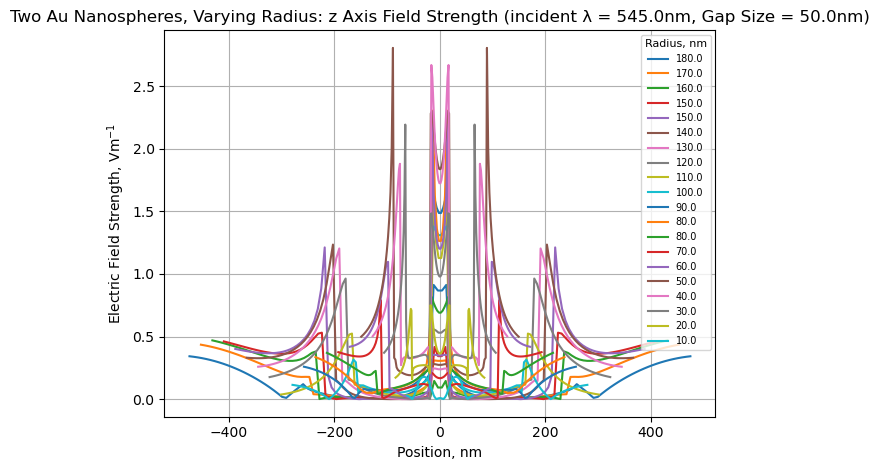

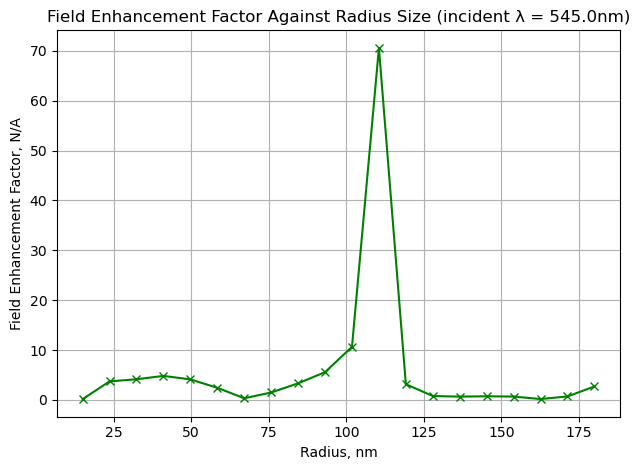

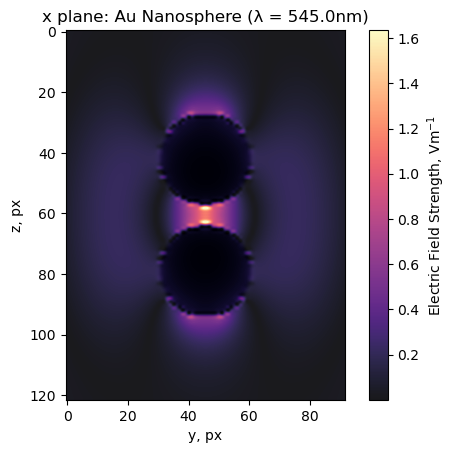

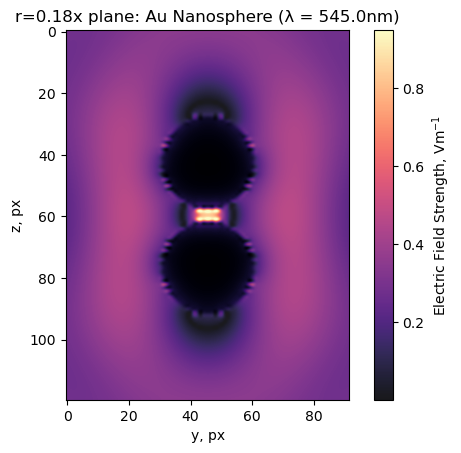

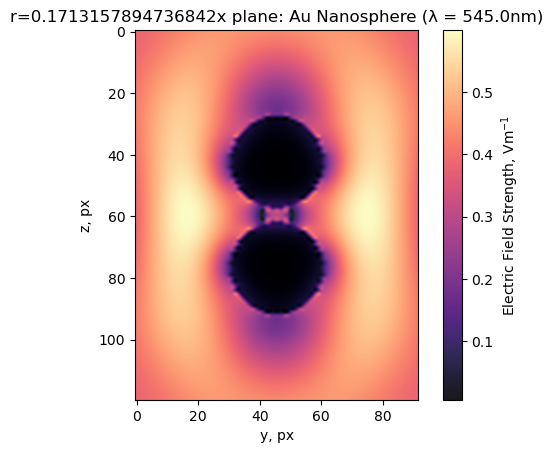

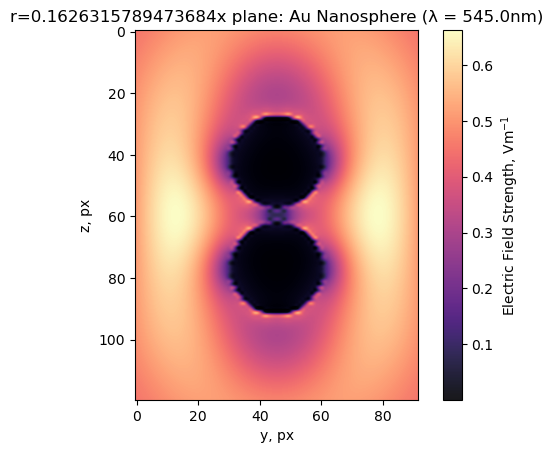

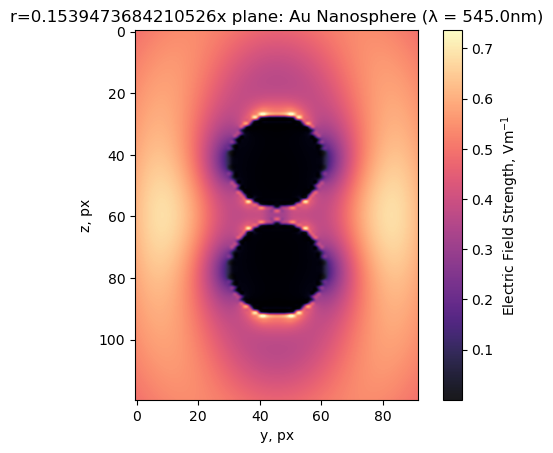

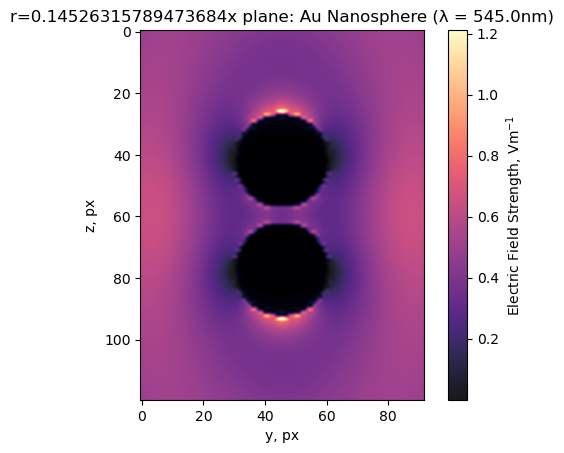

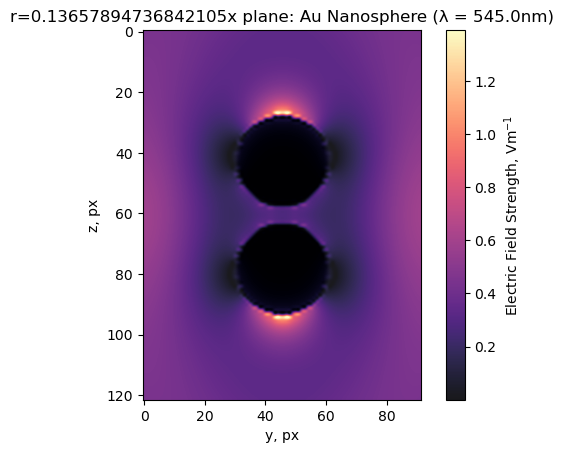

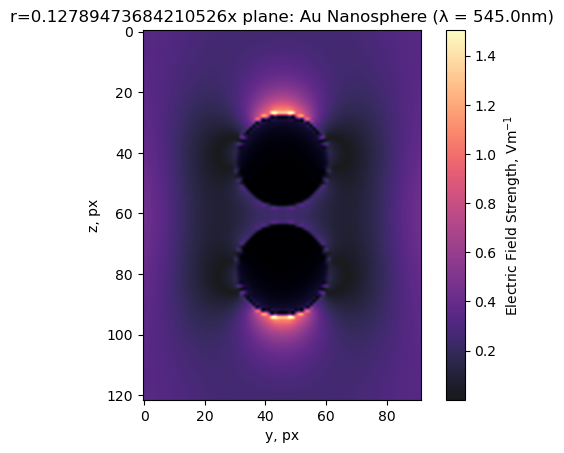

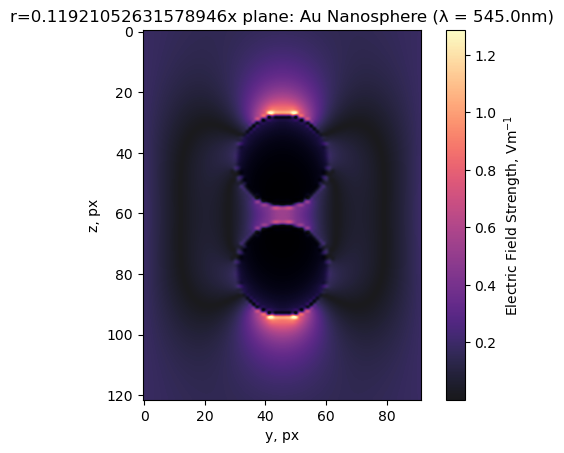

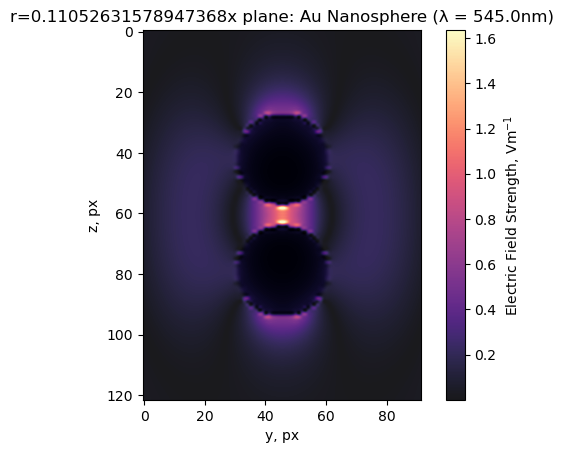

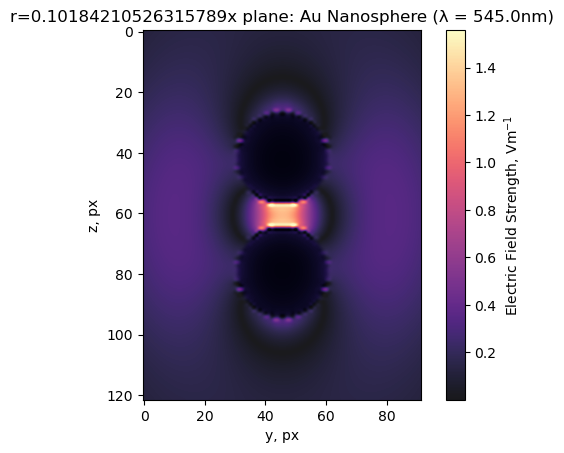

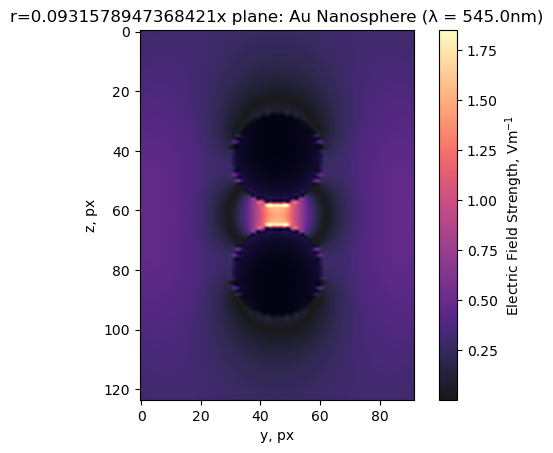

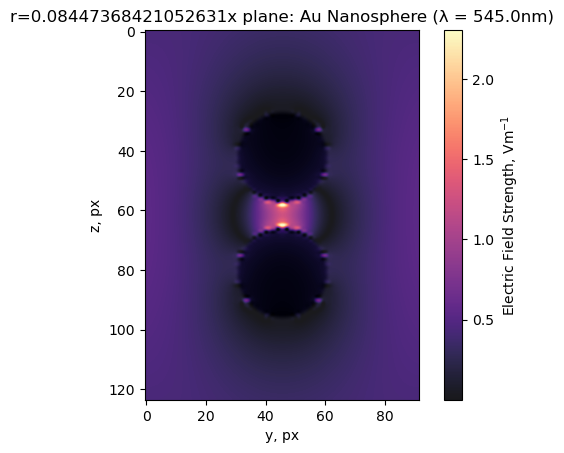

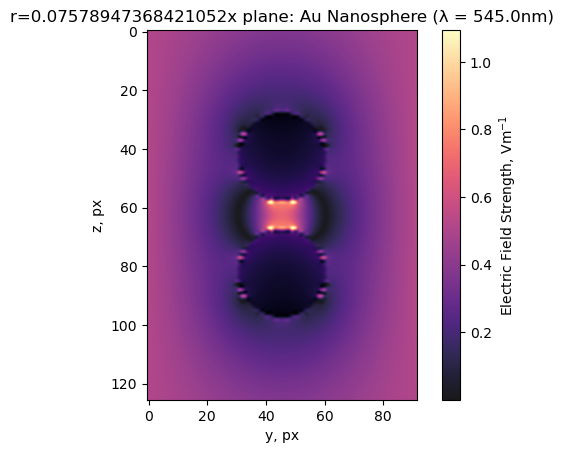

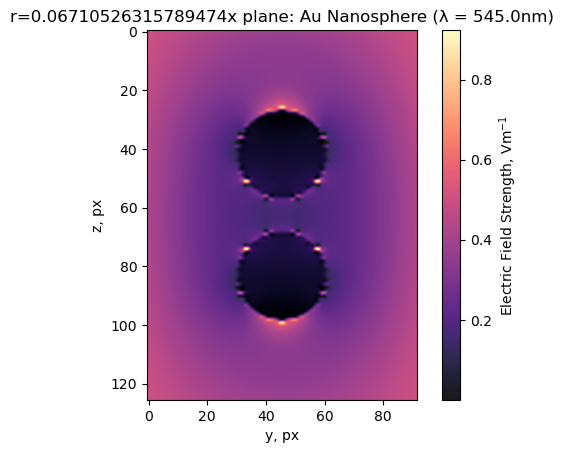

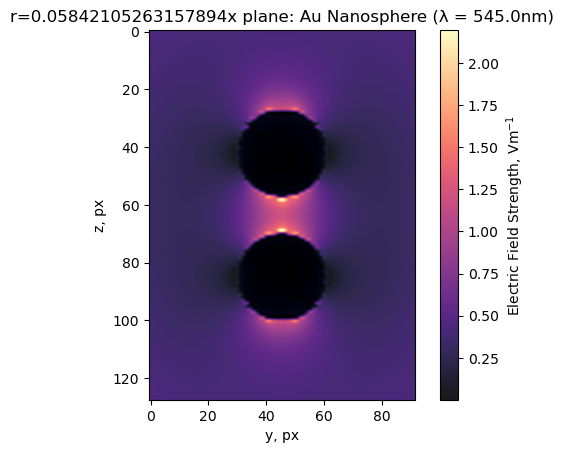

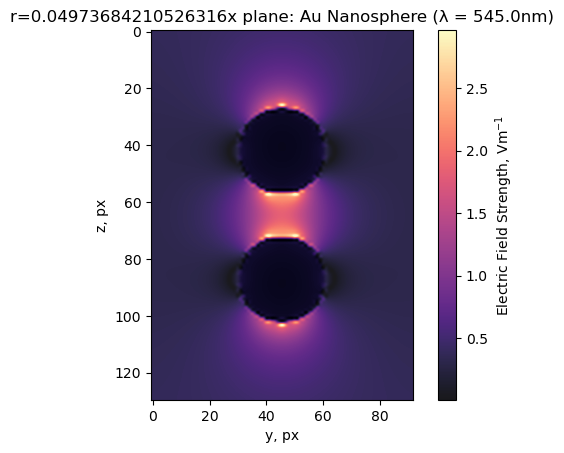

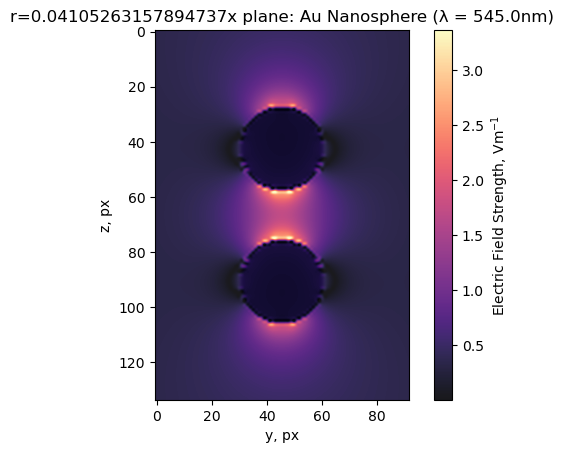

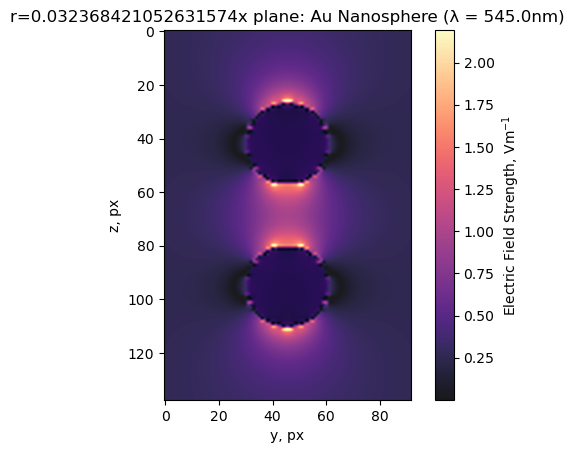

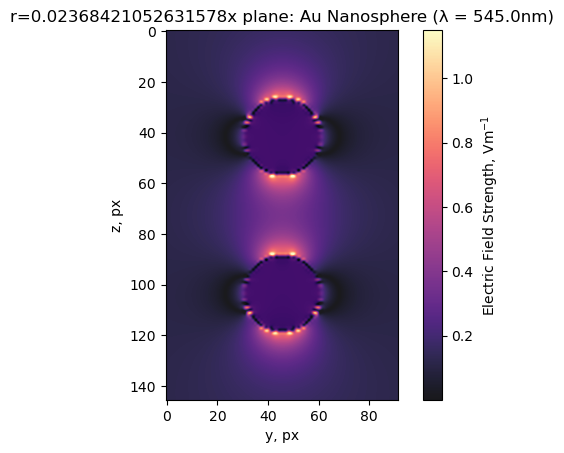

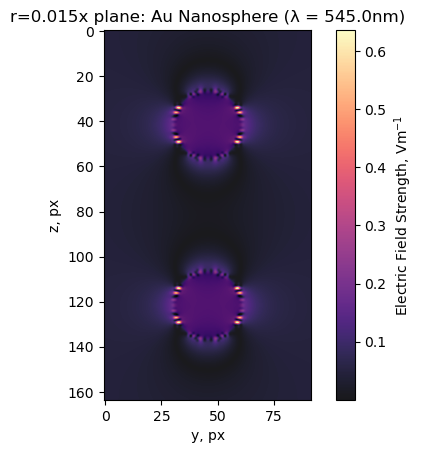

In [9]:
FEF_values = []
print(inc_field_vals)

index = 0

plt.figure()
for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = (radii[index]*5+gap)/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))
    #Also converting axis to position from pixels. 100 being the resolution value.

    FEF_values.append(np.interp(0.0, space_1D, E_strength) / inc_field_vals[index])

    #plt.figure()
    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(radii[index]),2))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Two Au Nanospheres, Varying Radius: z Axis Field Strength (incident λ = {wvl*1E3}nm, Gap Size = {gap*1E3}nm)")
    plt.legend(loc="upper right", title = "Radius, nm", fontsize = 7, title_fontsize= 8)
    plt.tight_layout()
    #plt.show()
    
    index+=1

plt.savefig(fname="Two Au Nanospheres, Varying Radius: z Axis Field Strength",
        dpi=150, 
        bbox_inches="tight")

plt.figure()
plt.plot(1E3*radii, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Radius Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Radius Size",
        dpi=150, 
        bbox_inches="tight")


#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("y, px")
plt.ylabel("z, px")
plt.title(f"x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
plt.savefig(fname=f"run=x plane: Two Au Nanospheres, greatest FEF, rad",
    dpi=150, 
    bbox_inches="tight")


for index in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    plt.figure()
    plt.imshow(eps_data_vis[index].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[index].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("y, px")
    plt.ylabel("z, px")
    plt.title(f"r={radii[index]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.savefig(fname=f"run={index}x plane: Two Au Nanospheres, rad",
        dpi=150, 
        bbox_inches="tight")


In [ ]:
#manual for gap vary

FEF_values_man = [0.3179232790004016, 5.6163848161999, 7.105411963811891, 7.82611894497935, 9.616469135560349,
                 7.7, 6.7, 5.75, 5.05, 4.75, 4.4, 3.95, 3.5, 3.3, 3.1, 2.85, 2.75, 2.54, 2.4, 2.31, 2.19, 2.1, 2]
gaps_man = np.array([6, 8.25, 10.5, 12.75, 15,
                      18.9, 24.8, 30.8, 36.7, 42.7, 48.59, 54.6, 60.5, 66.5, 72.4, 78.39, 84.3, 90.3, 96.19, 102.2, 108.1, 114.1, 120])


plt.figure()
plt.plot(gaps_man, FEF_values_man, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Gap Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Gap Size",
        dpi=150, 
        bbox_inches="tight")
